In [1]:
import sys
sys.path.append('../')

from src.cmesrc.config import CMESRCV2_DB
from src.cmesrc.classes import Point, InvalidBoundingBox
from src.harps.harps import Harps
import sqlite3
import pandas as pd
from tqdm import tqdm
import numpy as np

In [2]:
conn = sqlite3.connect(CMESRCV2_DB)
cur = conn.cursor()

In [25]:
cur.executescript("""
CREATE INDEX IF NOT EXISTS idx_majumdar_cme_id ON MAJUMDAR_SRC (cme_id);
CREATE INDEX IF NOT EXISTS idx_cmes_cme_id ON CMES (cme_id);
CREATE INDEX IF NOT EXISTS idx_cmes_cme_id_date ON CMES (cme_id, cme_date); -- Optional
CREATE INDEX IF NOT EXISTS idx_harps_start_end ON HARPS (start, end); -- Optional
CREATE INDEX IF NOT EXISTS idx_phbb_harpnum ON PROCESSED_HARPS_BBOX (harpnum);
CREATE INDEX IF NOT EXISTS idx_phbb_harpnum_timestamp ON PROCESSED_HARPS_BBOX (harpnum, timestamp); -- Optional
                  """)
df = pd.read_sql(
    """
    WITH cme_harpnum AS (
  SELECT M.cme_id, M.cme_pa, M.cme_width, M.sr_type, C.cme_date, H.harpnum, C.image_timestamp, M.sr_lon, M.sr_lat, FCHA.harpnum AS my_harpnum
  FROM MAJUMDAR_SRC M
  INNER JOIN CMES C
  ON C.cme_id = M.cme_id
  INNER JOIN HARPS H
  ON C.cme_date BETWEEN H.start AND H.end
  LEFT JOIN FINAL_CME_HARP_ASSOCIATIONS FCHA
  ON C.cme_id = FCHA.cme_id
  WHERE C.cme_date > (SELECT MIN(HBB.timestamp) FROM HARPS_BBOX HBB) AND M.sr_lon BETWEEN -90 AND 90
  AND H.harpnum IN (SELECT DISTINCT harpnum FROM PROCESSED_HARPS_BBOX)
),
RankedResults AS (
  SELECT 
  ch.cme_id,
  ch.harpnum,
	ch.cme_date,
	ch.image_timestamp,
  HBB.timestamp,
	HBB.LONDTMIN,
	HBB.LONDTMAX,
	HBB.LATDTMIN,
	HBB.LATDTMAX,
  HBB.area,
	ch.sr_lon,
	ch.sr_lat,
  ch.cme_pa,
  ch.sr_type,
  ch.cme_width,
  ch.my_harpnum,
    ROW_NUMBER() OVER (PARTITION BY ch.cme_id, ch.harpnum ORDER BY ABS(strftime('%s', ch.cme_date) - strftime('%s', HBB.timestamp)) ASC) AS rn,
	ABS(strftime('%s', ch.cme_date) - strftime('%s', HBB.timestamp)) as diff
  FROM cme_harpnum ch
  INNER JOIN HARPS_BBOX HBB
  ON ch.harpnum = HBB.harpnum
)
SELECT cme_id, cme_date, sr_type, cme_pa, cme_width, harpnum, timestamp, image_timestamp, diff, LONDTMIN, sr_lon, LONDTMAX, LATDTMIN, sr_lat, LATDTMAX, my_harpnum, area
FROM RankedResults
WHERE rn = 1;
""", conn
)


In [26]:
df[["ROTATED_LATDTMIN", "ROTATED_LATDTMAX", "ROTATED_LONDTMIN", "ROTATED_LONDTMAX"]] = np.nan

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    harps_date = row['timestamp']
    cme_date = row['cme_date']
    lon_min, lon_max, lat_min, lat_max = row[['LONDTMIN', 'LONDTMAX', 'LATDTMIN', 'LATDTMAX']].values

    point_lon, point_lat = row[['sr_lon', 'sr_lat']].values
    point_date = row['cme_date']

    harps = Harps(
        date=harps_date,
        lon_min=lon_min,
        lat_min=lat_min,
        lon_max=lon_max,
        lat_max=lat_max
    )
   
    point = Point(
        date=point_date,
        lon=point_lon,
        lat=point_lat
    )

    # Check if difference is larger than 1 hours
    if abs(point.DATE - harps.DATE).to_value('second') > 3600:
        rotated_harps = harps.rotate_bbox(point.DATE)
    else:
        rotated_harps = harps
 
    bottom_left, top_rigth = rotated_harps.get_raw_bbox()
    ROTATED_LONDTMIN, ROTATED_LATDTMIN = bottom_left
    ROTATED_LONDTMAX, ROTATED_LATDTMAX = top_rigth

    df.at[idx, 'ROTATED_LATDTMIN'] = ROTATED_LATDTMIN
    df.at[idx, 'ROTATED_LATDTMAX'] = ROTATED_LATDTMAX
    df.at[idx, 'ROTATED_LONDTMIN'] = ROTATED_LONDTMIN
    df.at[idx, 'ROTATED_LONDTMAX'] = ROTATED_LONDTMAX

    dist = rotated_harps.get_spherical_point_distance(point)
    
    df.at[idx, 'dist'] = dist

100%|██████████| 12728/12728 [00:37<00:00, 343.00it/s]


In [61]:
grouped = df.groupby('cme_id')
df["match"] = False

for cme_id, group in tqdm(grouped, total=grouped.ngroups):
        
    min_dist = group['dist'].min()

    if min_dist > 10 * np.pi / 180: # Max 10 degrees off
        continue

    my_match = group['my_harpnum'].values[0]

    possible_matches = group.loc[group['dist'] == min_dist]

    # Now, if my_match is in possible_matches, then we have a match
    if my_match in possible_matches['harpnum'].values:
        match = my_match
        match_idx = possible_matches[possible_matches['harpnum'] == my_match].index[0]
    else:
        # Otherwise sort duplicates by area and take the largest
        possible_matches = possible_matches.sort_values('area', ascending=False)
        match = possible_matches['harpnum'].values[0]
        match_idx = possible_matches.index[0]
    
    df.at[match_idx, 'match'] = True

    if cme_id == 20100904151209270:
        print(group[["harpnum","dist"]])
        print(min_dist)
        print(possible_matches)
        print(match)
        print("\n\n")
        print(df.loc[match_idx])

 72%|███████▏  | 1015/1409 [00:00<00:00, 3396.93it/s]

    harpnum      dist
6       145  0.006121
7       147  0.104033
8       152  1.384897
9       155  0.266557
10      156  0.412309
11      158  1.219462
12      161  1.403698
13      166  1.266884
0.006120869686726428
              cme_id             cme_date sr_type  cme_pa  cme_width  harpnum  \
6  20100904151209270  2010-09-04 15:12:09      AR   270.0      130.0      145   

             timestamp      image_timestamp  diff   LONDTMIN  ...  sr_lat  \
6  2010-09-04 15:12:00  2010-09-04 15:12:00     9  60.871201  ...     9.0   

   LATDTMAX  my_harpnum      area  ROTATED_LATDTMIN  ROTATED_LATDTMAX  \
6   15.2334       145.0  0.370615            9.3507           15.2334   

   ROTATED_LONDTMIN  ROTATED_LONDTMAX      dist  match  
6         60.871201         74.176804  0.006121  False  

[1 rows x 23 columns]
145.0



cme_id                20100904151209270
cme_date            2010-09-04 15:12:09
sr_type                              AR
cme_pa                            270.0
cme_width 

100%|██████████| 1409/1409 [00:00<00:00, 3187.30it/s]


In [63]:
matches = df[df["match"]][["cme_id", "harpnum", "dist"]]

# First reset matches
cur.execute("""
UPDATE MAJUMDAR_SRC
SET matching_harps = NULL, dist = NULL
""")

for cme_id, match, dist in zip(matches["cme_id"].values, matches["harpnum"].values, matches["dist"].values):
    cme_id = int(cme_id)
    match = int(match)
    cur.execute("""
    UPDATE MAJUMDAR_SRC
    SET matching_harps = ?, dist = ?
    WHERE cme_id = ?
    """, (match, dist, cme_id))

In [64]:
conn.commit()

In [65]:
# Add column dist to MAJUMDAR_SRC

cur.execute("""
ALTER TABLE MAJUMDAR_SRC
ADD COLUMN dist REAL;
""")

OperationalError: duplicate column name: dist

In [66]:
df[df["match"] & (~pd.isnull(df["my_harpnum"])) & (df["my_harpnum"] == df["harpnum"])][["harpnum", "my_harpnum"]]

,harpnum,my_harpnum
6,145,145.0
127,211,211.0
135,211,211.0
222,245,245.0
237,245,245.0
...,...,...
12590,7107,7107.0
12623,7110,7110.0
12629,7117,7117.0
12677,7148,7148.0


In [67]:
df[df["cme_id"] == 20131026191205074]

,cme_id,cme_date,sr_type,cme_pa,cme_width,harpnum,timestamp,image_timestamp,diff,LONDTMIN,...,sr_lat,LATDTMAX,my_harpnum,area,ROTATED_LATDTMIN,ROTATED_LATDTMAX,ROTATED_LONDTMIN,ROTATED_LONDTMAX,dist,match
10222,20131026191205074,2013-10-26 19:12:05,AR,74.0,207.0,3286,2013-10-26 19:12:00,2013-10-26 19:12:00,5,68.315804,...,-11.0,-14.155600,3311.0,0.616015,-20.646999,-14.155600,68.315804,88.839500,0.151960,True
10223,20131026191205074,2013-10-26 19:12:05,AR,74.0,207.0,3288,2013-10-26 19:12:00,2013-10-26 19:12:00,5,54.206799,...,-11.0,21.744600,3311.0,1.942682,7.878800,21.744600,54.206799,84.172096,0.329497,False
10224,20131026191205074,2013-10-26 19:12:05,AR,74.0,207.0,3291,2013-10-26 19:12:00,2013-10-26 19:12:00,5,30.087601,...,-11.0,18.128799,3311.0,2.552745,0.108100,18.128799,30.087601,59.802601,0.193903,False
10225,20131026191205074,2013-10-26 19:12:05,AR,74.0,207.0,3295,2013-10-26 19:12:00,2013-10-26 19:12:00,5,2.833400,...,-11.0,-7.080700,3311.0,2.432351,-22.364799,-7.080700,2.833400,36.874100,0.396108,False
10226,20131026191205074,2013-10-26 19:12:05,AR,74.0,207.0,3306,2013-10-26 19:12:00,2013-10-26 19:12:00,5,9.438900,...,-11.0,16.143400,3311.0,0.462304,7.729600,16.143400,9.438900,21.033199,0.751556,False
10227,20131026191205074,2013-10-26 19:12:05,AR,74.0,207.0,3309,2013-10-26 19:12:00,2013-10-26 19:12:00,5,-17.724400,...,-11.0,-19.891701,3311.0,0.343807,-25.197001,-19.891701,-17.724400,-3.246400,1.069638,False
10228,20131026191205074,2013-10-26 19:12:05,AR,74.0,207.0,3311,2013-10-26 19:12:00,2013-10-26 19:12:00,5,-60.294800,...,-11.0,-3.884600,3311.0,0.962840,-16.210400,-3.884600,-60.294800,-43.899700,1.767124,False
10229,20131026191205074,2013-10-26 19:12:05,AR,74.0,207.0,3313,2013-10-26 19:12:00,2013-10-26 19:12:00,5,-25.671101,...,-11.0,21.586700,3311.0,0.505495,14.035100,21.586700,-25.671101,-11.158400,1.306447,False
10230,20131026191205074,2013-10-26 19:12:05,AR,74.0,207.0,3316,2013-10-26 19:12:00,2013-10-26 19:12:00,5,-24.986300,...,-11.0,-10.438600,3311.0,0.045752,-12.695800,-10.438600,-24.986300,-20.718500,1.377779,False
10231,20131026191205074,2013-10-26 19:12:05,AR,74.0,207.0,3320,2013-10-26 19:12:00,2013-10-26 19:12:00,5,-84.174202,...,-11.0,7.534400,3311.0,0.380054,0.829600,7.534400,-84.174202,-72.444397,2.298515,False


In [68]:
# I don't trust their matches now...

# Add new column sr_pa

cur.execute("""
ALTER TABLE MAJUMDAR_SRC
ADD COLUMN sr_pa REAL;
""")

OperationalError: duplicate column name: sr_pa

In [69]:
# Now we calculate PA for every point

cur.execute("SELECT cme_id, cme_date, sr_lat, sr_lon FROM MAJUMDAR_SRC")
rows = cur.fetchall()

for row in tqdm(rows):
    cme_id, cme_date, sr_lat, sr_lon = row
    point = Point(date=cme_date, lon=sr_lon, lat=sr_lat)
    pa = point.get_position_angle()
    cur.execute("""
    UPDATE MAJUMDAR_SRC
    SET sr_pa = ?
    WHERE cme_id = ?
    """, (pa, cme_id))

100%|██████████| 3241/3241 [00:00<00:00, 12091.89it/s]


In [70]:
conn.commit()

In [71]:
pa_df = pd.read_sql("""
SELECT
cme_id, sr_pa, cme_pa, cme_width, sr_lat, sr_lon,
cme_pa + (cme_width/2) AS upper_pa,
cme_pa - (cme_width/2) AS lower_pa
FROM MAJUMDAR_SRC
""", conn)

In [72]:
pa_df.to_csv("/home/julio/pa_results.csv", index=False)

In [73]:
check_df = pd.read_sql("""
SELECT M.cme_id, M.matching_harps, M.sr_lon, M.sr_lat, 
strftime('%s', M.cme_date) - strftime('%s', HBB.timestamp) AS diff,
HBB.LONDTMIN, HBB.LATDTMIN, HBB.LONDTMAX, HBB.LATDTMAX
FROM MAJUMDAR_SRC M
INNER JOIN CMES C
ON M.cme_id = C.cme_id
INNER JOIN HARPS_BBOX HBB
ON M.matching_harps = HBB.harpnum AND C.image_timestamp = HBB.timestamp
WHERE diff < 12 * 60
LIMIT 100
                       """, conn)

In [74]:
check_df

,cme_id,matching_harps,sr_lon,sr_lat,diff,LONDTMIN,LATDTMIN,LONDTMAX,LATDTMAX
0,20100901140005242,145,27.0,6.0,5,19.655800,9.350700,32.961399,15.233400
1,20100904151209270,145,66.0,9.0,9,60.871201,9.350700,74.176804,15.233400
2,20100910184805142,175,-89.0,-21.0,5,-107.945801,-26.784100,-74.304199,-13.953300
3,20100911020006065,168,-20.0,25.0,6,-23.391600,25.843399,-10.692700,35.426399
4,20100911170005125,175,-84.0,-21.0,5,-95.592003,-26.784100,-61.950298,-13.953300
...,...,...,...,...,...,...,...,...,...
95,20110404155712061,480,-90.0,25.0,-168,-102.443001,12.678900,-62.786301,28.073900
96,20110404193607067,480,-70.0,24.0,7,-100.442902,12.678900,-60.786201,28.073900
97,20110404223605041,480,-67.0,25.0,5,-98.776199,12.678900,-59.119400,28.073900
98,20110407054807049,480,-57.0,25.0,7,-68.108002,12.678900,-28.451300,28.073900


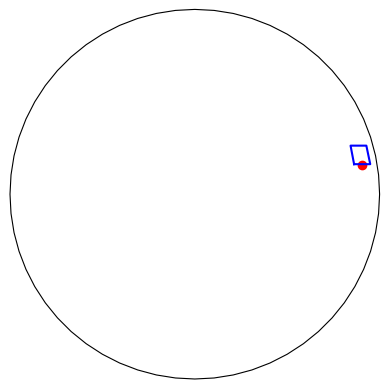

In [75]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

i = 1
projection = ccrs.Orthographic(central_longitude=0, central_latitude=0)

fig, ax = plt.subplots(subplot_kw={'projection': projection})

bbox = check_df[["LONDTMIN", "LONDTMAX", "LATDTMIN", "LATDTMAX"]].values[1]

point_lon, point_lat = check_df[["sr_lon", "sr_lat"]].values[1]

ax.plot([bbox[0], bbox[1], bbox[1], bbox[0], bbox[0]],
        [bbox[2], bbox[2], bbox[3], bbox[3], bbox[2]],
        transform=ccrs.Geodetic(),
        color='blue')

ax.scatter(point_lon, point_lat, transform=ccrs.Geodetic(), color='red')
ax.set_global()

In [41]:
df.to_csv("majumdar_figures/data.csv", index=False)

In [76]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.patches import Arc, Wedge
import pandas as pd

grouped = df.groupby('cme_id')

for cme_id, group in tqdm(grouped, total=grouped.ngroups):

    my_match_values = group['my_harpnum'].values
    my_match = int(my_match_values[0]) if not pd.isnull(my_match_values[0]) else None

    # Check if there are matching values before accessing
    majumdar_match_values = group[group['match']]["harpnum"].values
    if len(majumdar_match_values) == 0:
        majumdar_match = None
    else:
        majumdar_match = int(majumdar_match_values[0]) if not pd.isnull(majumdar_match_values[0]) else None

    projection = ccrs.Orthographic(central_longitude=0, central_latitude=0)
    fig, ax = plt.subplots(subplot_kw={'projection': projection})

    # Check if there are lon and lat values before accessing
    point_values = group[['sr_lon', 'sr_lat']].values
    point_lon, point_lat = point_values[0]

    ax.scatter(point_lon, point_lat, transform=ccrs.Geodetic(), color='red')

    # Retrieve CME parameters (cme_pa and cme_width) for the group
    cme_pa_values = group['cme_pa'].values
    cme_width_values = group['cme_width'].values

    cme_pa = cme_pa_values[0]
    cme_width = cme_width_values[0]

    # Calculate starting and ending angles for the arc
    start_angle = cme_pa - cme_width / 2 + 90
    end_angle = cme_pa + cme_width / 2 + 90

    start_angle = start_angle % 360
    end_angle = end_angle % 360

    # Define the center and radius of the wedge in axis units
    center_in_axis_units = (0.5, 0.5)  # Center of the plot
    radius_in_axis_units = 0.7  # Half the width of the plot

    # Create a wedge to represent the CME
    cme_wedge = Wedge(center=center_in_axis_units, r=radius_in_axis_units,
                    theta1=start_angle, theta2=end_angle,
                    transform=ax.transAxes, color='orange', alpha=0.5)

    # Add the wedge to the plot
    ax.add_patch(cme_wedge)

    sr_type = group['sr_type'].values[0]

    for idx, row in group.iterrows():
        bbox = row[['ROTATED_LONDTMIN', 'ROTATED_LONDTMAX', 'ROTATED_LATDTMIN', 'ROTATED_LATDTMAX']].values
        harpnum = row['harpnum']

        if harpnum == my_match == majumdar_match:
            c = "purple"
            linestyle = "-"
        elif harpnum == my_match:
            c = "g"
            linestyle = "--"
        elif harpnum == majumdar_match:
            c = "b"
            linestyle = "-."
        else:
            c = "k"
            linestyle = "solid"

        ax.plot([bbox[0], bbox[1], bbox[1], bbox[0], bbox[0]],
                [bbox[2], bbox[2], bbox[3], bbox[3], bbox[2]],
                transform=ccrs.Geodetic(),
                color=c,
                linestyle=linestyle)

    ax.set_global()

    # Add the sr_type as a label on top left of the plot
    ax.text(0.01, 0.95, sr_type, transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.text(0.01, 0.05, f"{cme_pa}, {cme_width}", transform=ax.transAxes, fontsize=12, verticalalignment='top')

    plt.savefig(f"majumdar_figures/{cme_id}.png", dpi=150)
    plt.clf()
    plt.close()

100%|██████████| 1409/1409 [01:33<00:00, 15.04it/s]


In [77]:
df[df["cme_id"] == 20100904151209270]

,cme_id,cme_date,sr_type,cme_pa,cme_width,harpnum,timestamp,image_timestamp,diff,LONDTMIN,...,sr_lat,LATDTMAX,my_harpnum,area,ROTATED_LATDTMIN,ROTATED_LATDTMAX,ROTATED_LONDTMIN,ROTATED_LONDTMAX,dist,match
6,20100904151209270,2010-09-04 15:12:09,AR,270.0,130.0,145,2010-09-04 15:12:00,2010-09-04 15:12:00,9,60.871201,...,9.0,15.233400,145.0,0.370615,9.350700,15.233400,60.871201,74.176804,0.006121,True
7,20100904151209270,2010-09-04 15:12:09,AR,270.0,130.0,147,2010-09-04 15:12:00,2010-09-04 15:12:00,9,48.432800,...,9.0,25.610500,145.0,0.780176,14.671800,25.610500,48.432800,64.126198,0.104033,False
8,20100904151209270,2010-09-04 15:12:09,AR,270.0,130.0,152,2010-09-04 15:12:00,2010-09-04 15:12:00,9,-30.659100,...,9.0,25.422100,145.0,0.897301,12.856400,25.422100,-30.659100,-15.036900,1.384897,False
9,20100904151209270,2010-09-04 15:12:09,AR,270.0,130.0,155,2010-09-04 15:12:00,2010-09-04 15:12:00,9,63.778999,...,9.0,28.535601,145.0,0.169264,24.272600,28.535601,63.778999,72.924797,0.266557,False
10,20100904151209270,2010-09-04 15:12:09,AR,270.0,130.0,156,2010-09-04 15:12:00,2010-09-04 15:12:00,9,25.618500,...,9.0,22.677099,145.0,0.520626,16.081499,22.677099,25.618500,42.887501,0.412309,False
11,20100904151209270,2010-09-04 15:12:09,AR,270.0,130.0,158,2010-09-04 15:12:00,2010-09-04 15:12:00,9,-5.543000,...,9.0,-13.742100,145.0,0.127071,-19.253901,-13.742100,-5.543000,-0.581600,1.219462,False
12,20100904151209270,2010-09-04 15:12:09,AR,270.0,130.0,161,2010-09-04 15:12:00,2010-09-04 15:12:00,9,-16.131701,...,9.0,-18.226400,145.0,0.063192,-20.789200,-18.226400,-16.131701,-10.735600,1.403698,False
13,20100904151209270,2010-09-04 15:12:09,AR,270.0,130.0,166,2010-09-04 15:12:00,2010-09-04 15:12:00,9,-10.379500,...,9.0,2.834700,145.0,0.038468,0.609700,2.834700,-10.379500,-6.811600,1.266884,False
